# Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tld
!pip install pandas==1.3.4

     |████████████████████████████████| 412 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 14.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.


In [ ]:
# Imports you may need
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from tld import get_tld
from ast import literal_eval
from os import listdir
from wikidata.QueryManager import * 

# Load Data : sport quotes & occupation of the speakers

The loaded datasets have been obtained during Milestone 2. They contain quotes of sport media from year 2015 to 2020.

In [ ]:
# Load dataset containing sport quotes

sport_quotes_2015 = pd.read_csv('ada-sports-quotes/sport-quotes-2015.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2016 = pd.read_csv('ada-sports-quotes/sport-quotes-2016.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2017 = pd.read_csv('ada-sports-quotes/sport-quotes-2017.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2018 = pd.read_csv('ada-sports-quotes/sport-quotes-2018.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2019 = pd.read_csv('ada-sports-quotes/sport-quotes-2019.csv.bz2', compression='bz2', usecols=['qids'])
sport_quotes_2020 = pd.read_csv('ada-sports-quotes/sport-quotes-2020.csv.bz2', compression='bz2', usecols=['qids'])

df_all = pd.concat([sport_quotes_2015, sport_quotes_2016, sport_quotes_2017, sport_quotes_2018, sport_quotes_2019, sport_quotes_2020])
df_all.reset_index(inplace=True, drop=True)
df_all.head()

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('speaker_attributes.parquet', columns=['party', 'occupation', 'id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [ ]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
df_all['qids'] = df_all['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(df_all['qids'])]

# All sport quotes speakers : occupation distribution

In [ ]:
# Concatenate occupations of speakers who have multiples occupations
occupations = []

for i in range(speakers.shape[0]):
    occupations = np.concatenate((occupations, speakers['occupation'].iloc[i]), axis=None)

occupations = pd.DataFrame(occupations, columns=['occupation'])

In [ ]:
# Counts the occurences of each occupation and merging the corresponding label
occupation_counts_1_qid_speakers = pd.DataFrame(pd.value_counts(occupations['occupation']))
occupation_counts_label_1_qid_speakers = occupation_counts_1_qid_speakers.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid_speakers

,count,Label,Description
QID,,,
Q937857,22221,association football player,person who plays association football (soccer)...
Q82955,15766,politician,"person involved in politics, person who holds ..."
Q19204627,10517,American football player,sportsperson who is active in American football
Q33999,8853,actor,person who acts in a dramatic or comic product...
Q1650915,6649,researcher,"person who engages in research, professionally..."
...,...,...,...
Q104224827,1,disco singer,singer who sings disco songs
Q104224740,1,dansband singer,singer who sings in a dansband
Q24387326,1,mythographer,writer on mythology


In [ ]:
# Setting label of occupation with count lower than the .99 quantile to 'Others'
threshold_value = occupation_counts_label_1_qid_speakers['count'].quantile(.99)
values_below_thresh = occupation_counts_label_1_qid_speakers['count'] < threshold_value
occupation_counts_label_1_qid_speakers.loc[values_below_thresh,'Label'] = 'Others'

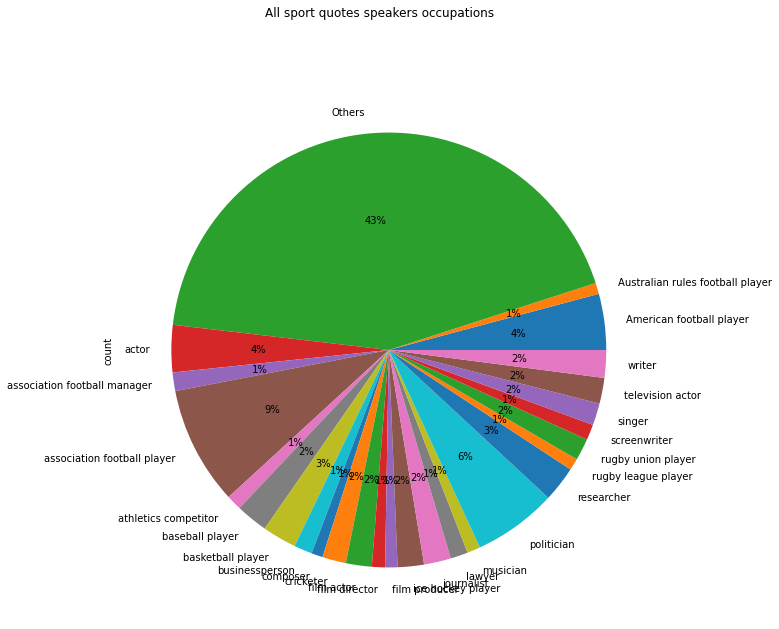

In [ ]:
# plot
fig = occupation_counts_label_1_qid_speakers.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='All sport quotes speakers occupations')
plt.savefig('sport_quotes_occupation_distribution.png')

# Speakers with political party : occupation distribution

In [ ]:
# Create subset of speakers with political party
politicians = speakers[~(speakers['party'].isna())]

print("Percentage of speakers with political party over sport quotes speakers :")
politicians.shape[0]/speakers.shape[0]*100

Percentage of speakers with political party over sport quotes speakers :


8.77958399673634

In [ ]:
# Devide politicians according to their number of occupation 
politiciansbis=politicians
politicians_none_qid = []
politicians_1_qid = []
politicians_many_qid = []

for i in range(politiciansbis.shape[0]):
    if politiciansbis['occupation'].iloc[i] is None:
        politicians_none_qid.append(politiciansbis['occupation'].iloc[i])
    elif len(politiciansbis['occupation'].iloc[i]) == 1 :
           politicians_1_qid.append(politiciansbis['occupation'].iloc[i])
    elif len(politiciansbis['occupation'].iloc[i]) > 1 :
             politicians_many_qid.append(politiciansbis['occupation'].iloc[i])
    else :
             politicians_none_qid.append(politiciansbis['occupation'].iloc[i])

politicians_none_qid = pd.DataFrame(politicians_none_qid, columns=['occupation'])
politicians_1_qid = pd.DataFrame(politicians_1_qid, columns=['occupation'])

In [ ]:
# Devide speakers with several occupations based on if one of their occupations is politician
politicians_many_qid_politician = np.array([])
politicians_many_qid_no_politician = np.array([])
nb_politicians_many_qid_politician = 0
nb_politicians_many_qid_no_politician = 0
for item in politicians_many_qid :
    if 'Q82955' in item :
        politicians_many_qid_politician = np.concatenate((politicians_many_qid_politician, item), axis=None)
        nb_politicians_many_qid_politician+=1
    else : 
        politicians_many_qid_no_politician = np.concatenate((politicians_many_qid_no_politician, item), axis=None)
        nb_politicians_many_qid_no_politician+=1

politicians_many_qid_politician = pd.DataFrame(politicians_many_qid_politician, columns=['occupation'])
politicians_many_qid_no_politician = pd.DataFrame(politicians_many_qid_no_politician, columns=['occupation'])

In [ ]:
print("Percentage of people with one occupation over sport quotes speakers with a party :")
print(politicians_1_qid.shape[0]/politicians.shape[0]*100)
print("Percentage of people with several occupations including politician over sport quotes speakers with a party :")
print(nb_politicians_many_qid_politician/politicians.shape[0]*100)
print("Percentage of people with several occupations excluding politician over sport quotes speakers with a party :")
print(nb_politicians_many_qid_no_politician/politicians.shape[0]*100)
print("Percentage of people without occupation over sport quotes speakers with a party :")
print(politicians_none_qid.shape[0]/politicians.shape[0]*100)

Percentage of people with one occupation over sport quotes speakers with a party :
59.03194578896418
Percentage of people with several occupations including politician over sport quotes speakers with a party :
33.47531461761859
Percentage of people with several occupations excluding politician over sport quotes speakers with a party :
6.040658276863504
Percentage of people without occupation over sport quotes speakers with a party :
1.452081316553727


In [ ]:
# Counts the occurences of each occupation and merging the corresponding label FOR 1 OCCUPATION
occupation_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid['occupation']))
occupation_counts_label_1_qid = occupation_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_1_qid.head()
occupation_counts_label_1_qid.tail()

# Counts the occurences of each occupation and merging the corresponding label FOR MANY OCCUPATIONS - POLITICIAN
occupation_counts_many_qid_politician = pd.DataFrame(pd.value_counts(politicians_many_qid_politician['occupation']))
occupation_counts_label_many_qid_politician = occupation_counts_many_qid_politician.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_many_qid_politician.head()
occupation_counts_label_many_qid_politician.tail()

# Counts the occurences of each occupation and merging the corresponding label FOR MANY OCCUPATIONS - NO POLITICIAN
occupation_counts_many_qid_no_politician = pd.DataFrame(pd.value_counts(politicians_many_qid_no_politician['occupation']))
occupation_counts_label_many_qid_no_politician = occupation_counts_many_qid_no_politician.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'occupation': 'count'})
occupation_counts_label_many_qid_no_politician

,count,Label,Description
QID,,,
Q33999,234,actor,person who acts in a dramatic or comic product...
Q10800557,216,film actor,actor who appears in films
Q10798782,216,television actor,actor who performs on television
Q36180,162,writer,person who uses written words to communicate i...
Q40348,156,lawyer,legal professional who helps clients and repre...
...,...,...,...
Q10669499,1,naval officer,commissioned officer serving in a navy
Q721834,1,manager,supporting character in professional wrestling
Q10730252,1,radio DJ,someone who broadcasts music on the radio


In [ ]:
# Setting label of occupation with count lower than the .98 quantile to 'Others' FOR 1 OCCUPATION
threshold_value = occupation_counts_label_1_qid['count'].quantile(.98)
values_below_thresh = occupation_counts_label_1_qid['count'] < threshold_value
print(occupation_counts_label_1_qid.loc[values_below_thresh,'Label'])
occupation_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

# Setting label of occupation with count lower than the .98 quantile to 'Others' FOR MANY OCCUPATIONS - POLITICIAN
occupation_counts_label_many_qid_politician = occupation_counts_label_many_qid_politician[occupation_counts_label_many_qid_politician['Label']!='politician']
threshold_value = occupation_counts_label_many_qid_politician['count'].quantile(.98)
values_below_thresh = occupation_counts_label_many_qid_politician['count'] < threshold_value
print(occupation_counts_label_many_qid_politician.loc[values_below_thresh,'Label'])
occupation_counts_label_many_qid_politician.loc[values_below_thresh,'Label'] = 'Others'

# Setting label of occupation with count lower than the .98 quantile to 'Others' FOR MANY OCCUPATIONS - NO POLITICIAN
threshold_value = occupation_counts_label_many_qid_no_politician['count'].quantile(.98)
values_below_thresh = occupation_counts_label_many_qid_no_politician['count'] < threshold_value
print(occupation_counts_label_many_qid_no_politician.loc[values_below_thresh,'Label'])
occupation_counts_label_many_qid_no_politician.loc[values_below_thresh,'Label'] = 'Others'

QID
Q193391                                     diplomat
Q19204627                   American football player
Q188094                                    economist
Q36180                                        writer
Q15627169                             trade unionist
                              ...                   
Q2986228                          sports commentator
Q2462658                                     manager
Q1518581     list of Ministers of Interior of Russia
Q29169143                             data scientist
Q836971                              party secretary
Name: Label, Length: 162, dtype: object
QID
Q806798                  banker
Q33999                    actor
Q185351                  jurist
Q212238           civil servant
Q47064       military personnel
                    ...        
Q16947320         geopolitician
Q97767991                   NaN
Q730242              test pilot
Q6859454          web developer
Q46961                 gangster
Name: Label, Leng

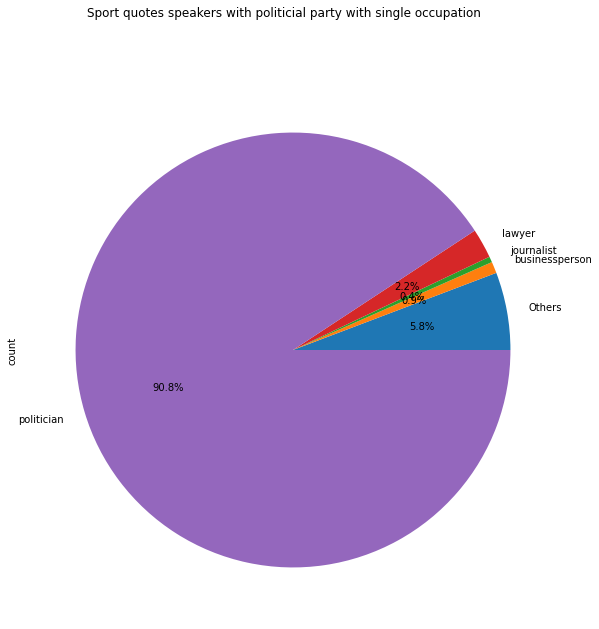

In [ ]:
# plot
fig = occupation_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.1f%%', title='Sport quotes speakers with politicial party with single occupation')
plt.savefig('politicians_occupation_distribution_1_occupation.png')

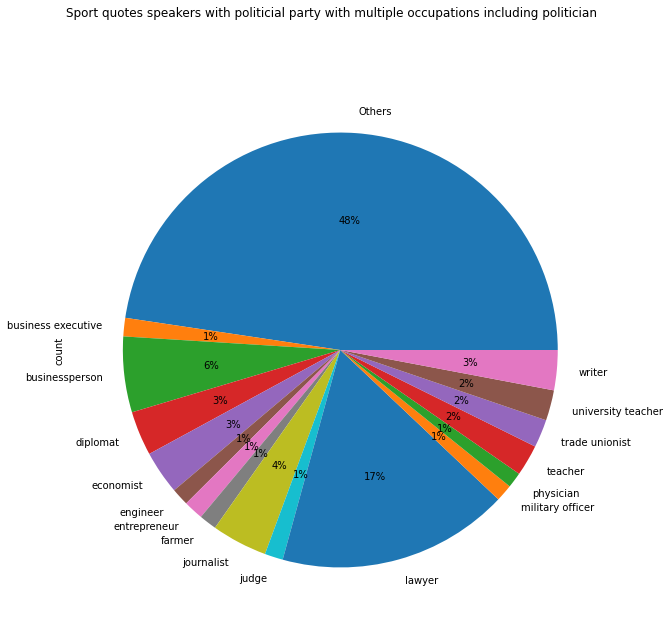

In [ ]:
# plot
fig = occupation_counts_label_many_qid_politician.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Sport quotes speakers with politicial party with multiple occupations including politician')
plt.savefig('politicians_occupation_distribution_politics.png')

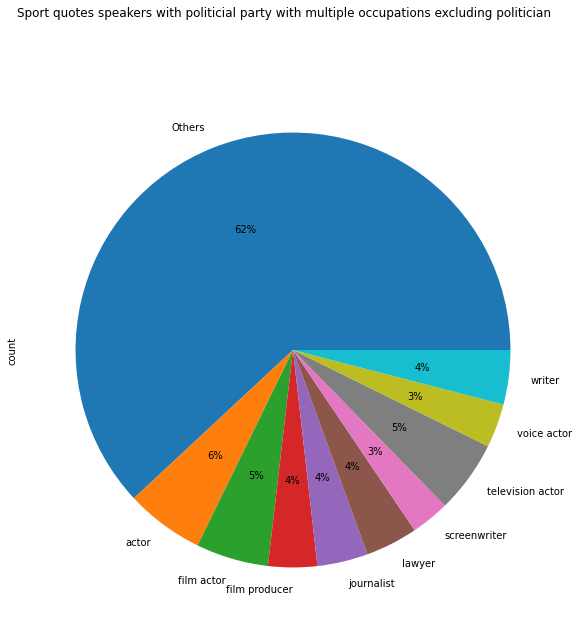

In [ ]:
# plot
fig = occupation_counts_label_many_qid_no_politician.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Sport quotes speakers with politicial party with multiple occupations excluding politician')
plt.savefig('politicians_occupation_distribution_1_non_politics.png')

## Extracting party information from `QIDs`

We decided to fetch information online using the [wikidata API](https://www.wikidata.org/wiki/Property:P6269). Our `QueryManager` allows us to retrieve:
 - a party full name from its wikidata `qid` (e.g. 'Q29552' => 'Democratic party')
 - the country a party is located in (e.g. 'Republican party' => 'United States of America') if available
 - the political tendency of a party (e.g. 'Republican party' => 'right-wing') if available
 
:warning: The `QueryManager` is in part inspired from a wikipast bot module written fully by one of the group member ([Source](https://github.com/RaulinN/BA6_SHS_DH)) giving full consent for its reutilization

We start by defining the concept of `JsonObject` as the preferred modern way of retrieving online information from most (if not all) APIs is using JSON

In [ ]:
import json

class JsonObject:
    """
    Class that represents a JSON object
    Attributes:
      - params: dict[str, str]
            JSON object in one of its string forms
    """

    def __init__(self, params: dict):
        self.json = params

    def prettyFormat(self):
        """Generates a pretty printable string representation of the JSON object"""
        return json.dumps(self.json, indent = 4, sort_keys = True)

    def prettyPrint(self):
        """Pretty prints the JSON object"""
        print(self.prettyFormat())


We then define a `Query` class that will be used to model a HTML GET query

In [ ]:
ANSWER_FORMAT: str = 'json'  # (query and) answer format

class Query:
    """
    Class that represents a network query
    Attributes:
      - params: dict[str, str]
            Payload of the query (dictionary representation of json object)
      - url: str
            The URL to which the query should be sent
    """

    WIKIDATA_BASE_URL = 'https://www.wikidata.org/w/api.php'

    def __init__(self, params: dict, url: str = WIKIDATA_BASE_URL):
        self.params = params
        self.url = url


def build_action_wb_get_entities(qid: str, props: str = 'claims') -> Query:
    return Query({
        "action": "wbgetentities",
        "ids": qid,
        "sites": "enwiki",
        "languages": "en",
        "sitefilter": "enwiki",
        "props": props,
        "format": ANSWER_FORMAT,
    })


def build_query_fetch_qid(page_title: str) -> Query:
    return Query({
        "action": "wbsearchentities",
        "search": page_title,
        "language": "en",
        "format": ANSWER_FORMAT,
        "uselang": "user",
        "errorformat": "bc",
    })


Our final component will be a simple cache for our query manager. We often have to query information for the same party multiple times, this component allows us to reduce execution time *significantly* by removing the need to perform useless GET requests

We obtained across all requests an average of 90.6% cache hit rate which cut the executing time by an (estimated) factor of 8

In [ ]:
from collections import deque

class Cache:
    """Represents a simple variable size cache"""

    def __init__(self, max_size: int):
        self.size = 0
        self.cache_max_size = max_size

        self.keys = deque(list(), max_size)
        self.map = dict()

    def add(self, key, value):
        if self.size == self.cache_max_size:
            old_key = self.keys.popleft()
            del self.map[old_key]
        else:
            self.size += 1

        self.map[key] = value
        self.keys.append(key)

    def get(self, key: str):
        if key in self.map:
            return self.map[key]

        return None


The last step is simply combining our building blocks together in order to create the `QueryManager`. Its principal public API includes:
- `search_party_name`: get the full party name from its QID
- `search_party_information`: get a party base country and political tendency
- `search_politician_party`: get the QID of the party associated to a politician at a given date

In [ ]:
import requests
import datetime

from typing import List, Dict


Qid = str

def _process_qid_answer(json_answer: JsonObject) -> str:
    """Extract QID from a JsonObject fetch qid answer"""
    try:
        # check that the answer is not empty
        searches = json_answer.json['search']

        if not searches:
            return ''

        return searches[0]['title']

    # in case we get an unexpected json answer (e.g. invalid fields)
    except Exception as e:
        print("_process_qid_answer encountered an unknown error: " + e.__str__())
        return ''


class QueryManager:
    class __QueryManager:
        """Inner class used to implement the singleton design pattern"""

        def __init__(self):
            self.session = requests.Session()
            self.country_map = dict()
            self.tendency_map = dict()
            self.politician_map = Cache(1)

    __instance = None  # Singleton QueryManager object

    def __init__(self):
        if not QueryManager.__instance:
            QueryManager.__instance = QueryManager.__QueryManager()

    def __getattr__(self, item):
        return getattr(self.__instance, item)


    def fetch_qid_information(self, qid: Qid, pids: List[str] = None) -> Dict[Qid, List]:
        """
        fetches information for specific pids from a page qid online on wikidata
        :param qid: qid of the page
        :param pids: pids you want to retrieve

        :example: self.fetch_qid_information('Q22686', ['P102'])  # returns all parties Donald Trump was/is part of
        """
        def claim_to_value(claim):
            if claim['mainsnak']['snaktype'] == 'novalue':
                return ''
            return claim['mainsnak']['datavalue']['value']['id']

        # fetch the content of the page with the corresponding qid
        query = Queries.build_action_wb_get_entities(qid)
        json_answer = self.send_get_query(query)

        if 'error' in json_answer.json.keys() or 'warning' in json_answer.json.keys():
            print(f'Encountered an error/warning when fetching information for qid = {qid}')
            json_answer.prettyPrint()
            return {}

        entity = json_answer.json['entities'][qid]

        if pids is None:
            return entity

        result: Dict[Qid, List] = dict()
        for pid in pids:
            try:
                value = map(claim_to_value, entity['claims'][pid])
                result.update({pid: [q for q in list(value) if q]})
            except:
                result.update({pid: list()})

        return result
    
    def search_party_name(self, party_qid: str) -> str:
        return self.fetch_qid_information(party_qid)

    def search_party_information(self, party: str, is_qid: bool = False, human_readable: bool = True) -> Dict[Qid, List[str]]:
        qid: Qid = party

        if not is_qid:
            query: Query = Queries.build_query_fetch_qid(party)
            json_answer = self.send_get_query(query)
            qid = _process_qid_answer(json_answer)

            if not qid:
                print(f'Could not fetch a qid for party name \'party\', is \'is_qid\' set to \'False\'?')
                return dict()

        party_information: Dict[Qid, List[Qid]] = self.fetch_qid_information(qid, ['P17', 'P1387'])

        if not human_readable:
            return party_information


        # Translate the country / tendency qids into human-readable strings
        country_qid = party_information.get('P17')[0] if len(party_information.get('P17')) != 0 else None
        tendency_qid = party_information.get('P1387')[0] if len(party_information.get('P1387')) != 0 else None

        # extract the value of the country from its country_qid
        if country_qid is not None:
            if country_qid in self.country_map:
                country_value = self.country_map.get(country_qid)
            else:
                query = Queries.build_action_wb_get_entities(country_qid, props = 'labels')
                json_answer = self.send_get_query(query)
                country_value = json_answer.json['entities'][country_qid]['labels']['en']['value']

                # add the newly found country_qid -> country_value tuple in the cache
                self.country_map.update({country_qid: country_value})

            party_information.update({'P17': [country_value]})


        # extract the value of the tendency from its tendency_qid
        if tendency_qid is not None:
            if tendency_qid in self.tendency_map:
                tendency_value = self.tendency_map.get(tendency_qid)
            else:
                query = Queries.build_action_wb_get_entities(tendency_qid, props = 'labels')
                json_answer = self.send_get_query(query)
                tendency_value = json_answer.json['entities'][tendency_qid]['labels']['en']['value']

                # add the newly found tendency_qid -> tendency_value tuple in the cache
                self.tendency_map.update({tendency_qid: tendency_value})

            party_information.update({'P1387': [tendency_value]})


        return party_information

    def search_politician_party(self, politician_qid: Qid, date_str: str = None) -> Qid:
        """
        Retrieve the party the politician with qid <politician_qid> was in at the time [date]
        If no date is specified, the current party is returned

        :param politician_qid: the qid of the politician we want the party
        :param date_str: the date of the request party membership (format: 'yyyy-mm')
        :return: the party (qid) the politician was in at [date]

        :example:
          - self.fetch_politician_party('Q22686') # fetches Donald Trump's current party
          - self.fetch_politician_party('Q22686', '2008-04') # fetches Donald Trump's party he was during 2008-04
        """

        def wiki_date_to_time_date(date_ws: str) -> datetime.date:
            """Turns a wikidata date (str) into a datetime.date"""
            time_list: List[str] = date_ws[1:].split('-')

            year: str = time_list[0] if int(time_list[0]) >= 0 else '0'
            month: str = time_list[1] if int(time_list[1]) in range(1, 13) else '01'

            return datetime.date(int(year), int(month), 1)


        parties = list()
        cached = self.politician_map.get(politician_qid)

        if cached is not None:
            parties = cached
        else:
            try:
                parties = self.fetch_qid_information(politician_qid)['claims']['P102']
                # self.politician_map[politician_qid] = parties
                self.politician_map.add(politician_qid, parties)
            except Exception:
                pass

        if len(parties) == 0:
            return ''

        if date_str is None:
            return parties[-1]['mainsnak']['datavalue']['value']['id']


        date_list = list(map(lambda x: int(x), date_str.split('-')))
        date = datetime.date(*date_list, 1)

        # first pass: try to see if we have parties that would tie with the date
        for party in reversed(parties):
            if party['mainsnak']['snaktype'] != 'novalue':
                if 'qualifiers' not in party:
                    continue

                if 'P582' in party['qualifiers']:  # if there's a "end time" for the party membership
                    end_date = wiki_date_to_time_date(party['qualifiers']['P582'][0]['datavalue']['value']['time'])
                    if date > end_date:
                        return ''

                if 'P580' in party['qualifiers']:  # if there's a "start time" for the party membership
                    start_date = wiki_date_to_time_date(party['qualifiers']['P580'][0]['datavalue']['value']['time'])
                    if date >= start_date:
                        return party['mainsnak']['datavalue']['value']['id']

        # second pass: return the last known party, because wikidata decides to sometimes omit the "start_time" and "end_time"
        for party in reversed(parties):
            if party['mainsnak']['snaktype'] != 'novalue':
                return party['mainsnak']['datavalue']['value']['id']

        return ''

    def send_get_query(self, query: Query):
        answer = self.session.get(url=query.url, params=query.params)
        return JsonObject(answer.json())


We can now use the `QueryManager` to our advantage when processing data with pandas.

In [ ]:
manager = QueryManager()

The following datasets from year 2015 to 2020 have been obtained during Milestone 2. They correspond to politicians sport quotes, which refers at quotations said by speakers having a political party. 

In [2]:
# loading quotes dataset

df_2015 = pd.read_csv('quotes_by_politicians_2015.csv')
df_2016 = pd.read_csv('quotes_by_politicians_2016.csv')
df_2017 = pd.read_csv('quotes_by_politicians_2017.csv')
df_2018 = pd.read_csv('quotes_by_politicians_2018.csv')
df_2019 = pd.read_csv('quotes_by_politicians_2019.csv')
df_2020 = pd.read_csv('quotes_by_politicians_2020.csv')

df = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020])
df.reset_index(inplace=True, drop=True)
df.head()

,index_q,quoteID,quotation,speaker,qids,date
0,0,2015-08-03-026031,I am not a poster child for the Christie admin...,Bill Pascrell,Q529090,2015-08-03 17:44:16
1,1,2015-08-03-002773,Accidents occur where the street meets the rai...,Bill Pascrell,Q529090,2015-08-03 17:44:16
2,2,2015-02-26-089365,These federal investments will go a long way t...,Bill Pascrell,Q529090,2015-02-26 07:55:10
3,3,2015-02-14-027291,"Looking back, it seems that every several mont...",Bill Pascrell,Q529090,2015-02-14 00:12:20
4,4,2015-08-03-088419,This is just one of many crossings that need i...,Bill Pascrell,Q529090,2015-08-03 17:44:16


We thus add a `current_party` field (at the time of the quote) to each quote

In [ ]:
for df_ann in [df_2015, df_2016, df_2017, df_2018, df_2019, df_2020]:
    df_ann['current_party'] = [None] * df_ann.shape[0]
    
    for i in range(df_ann.shape[0]):
        date = str(df_ann['quoteID'].loc[i][0:7])
        
        try:
            politician_qid = df_ann['qids'].loc[i]
            party_qid = manager.search_politician_party(politician_qid, date)
            df_ann.loc[i, 'current_party'] = party_qid
        except Exception as e:
            print(f"Error encountered for qid '{df_ann['qids'].loc[i]}': ", e)
    
    
    year = df_ann['quoteID'].loc[i][0:4]
    df_ann.to_csv('quotes_by_politician_with_party/' + year + '.csv')


# Load Data : politicians sport quotes & party of politicians

Politicians sport quotes refers at quotations said by speakers having a political party. Theses datasets from year 2015 to 2020 have been obtained during Milestone 2.

In [ ]:
#loading quotes dataset

df_2015 = pd.read_csv('quotebank_politician_with_party/2015.csv.bz2', compression='bz2')
df_2016 = pd.read_csv('quotebank_politician_with_party/2016.csv.bz2', compression='bz2')
df_2017 = pd.read_csv('quotebank_politician_with_party/2017.csv.bz2', compression='bz2')
df_2018 = pd.read_csv('quotebank_politician_with_party/2018.csv.bz2', compression='bz2')
df_2019 = pd.read_csv('quotebank_politician_with_party/2019.csv.bz2', compression='bz2')
df_2020 = pd.read_csv('quotebank_politician_with_party/2020.csv.bz2', compression='bz2')


df = pd.concat([df_2015, df_2016, df_2017, df_2018, df_2019, df_2020])
df.reset_index(inplace=True, drop=True)

# Which political parties or politicians are the most present in the sports quotes?

## Parties

In [ ]:
# Only keeping the first qid in the party feature
politicians_1_qid = df['current_party']
politicians_1_qid.shape

# Counts the occurences of each party and merging the corresponding label
party_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid))
party_counts_label_1_qid = party_counts_1_qid.merge(qid_labels, left_index=True, right_on='QID').rename(columns={'current_party': 'count'})
party_counts_label_1_qid.head(3)

,count,Label,Description
QID,,,
Q29468,105568,Republican Party,major political party in the United States
Q29552,84733,Democratic Party,political party in the United States
Q10230,14266,Bharatiya Janata Party,major political party in India


In [ ]:
# Setting label of party with count lower than the .99 quantile to 'Others'
threshold_value = party_counts_label_1_qid['count'].quantile(.99)
values_below_thresh = party_counts_label_1_qid['count'] < threshold_value
party_counts_label_1_qid.loc[values_below_thresh,'Label'] = 'Others'

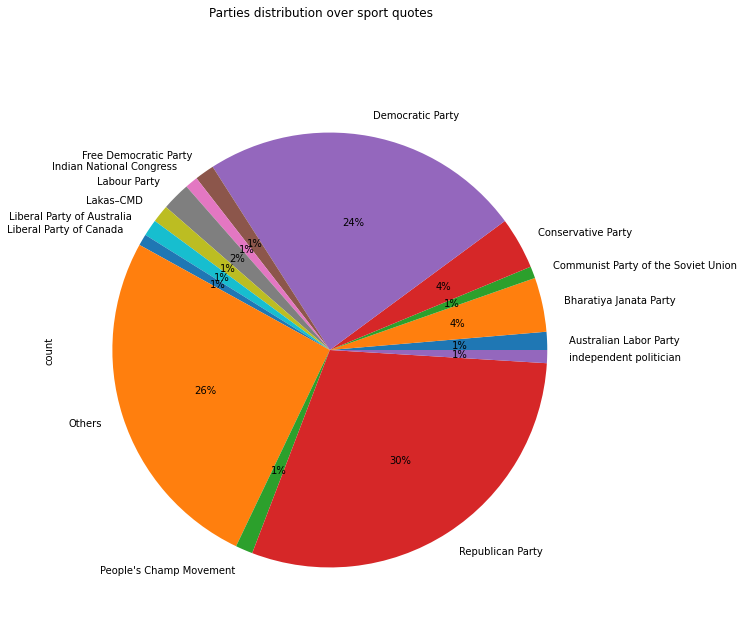

In [ ]:
fig = party_counts_label_1_qid.groupby('Label').sum().plot(kind='pie', subplots=True, figsize=(10, 10), legend=False, autopct='%1.f%%', title='Parties distribution over sport quotes')
plt.savefig('most_present_political_parties.png')

## Politicians

In [ ]:
# Only keeping the first qid in the party feature
politicians_1_qid = df['speaker']
politicians_1_qid

# Counts the occurences of each party and merging the corresponding label
politician_counts_1_qid = pd.DataFrame(pd.value_counts(politicians_1_qid))
politician_counts_label_1_qid = politician_counts_1_qid.rename(columns={'speaker': 'count'})
politician_counts_label_1_qid

,count
President Donald Trump,9295
Gabe Kapler,6470
Roger Goodell,6409
Adam Silver,5914
Thomas Bach,5076
...,...
Mohamed ElBaradei,1
Andrej Danko,1
Rosol Wahid,1
Moeletsi Mbeki,1


In [ ]:
# Aggregate Donald Trump quotes
politician_counts_label_1_qid.loc['President Donald Trump', 'count'] = politician_counts_label_1_qid.loc['President Donald Trump', 'count'] + politician_counts_label_1_qid.loc['President Trump', 'count']
politician_counts_label_1_qid = politician_counts_label_1_qid.drop(index='President Trump')

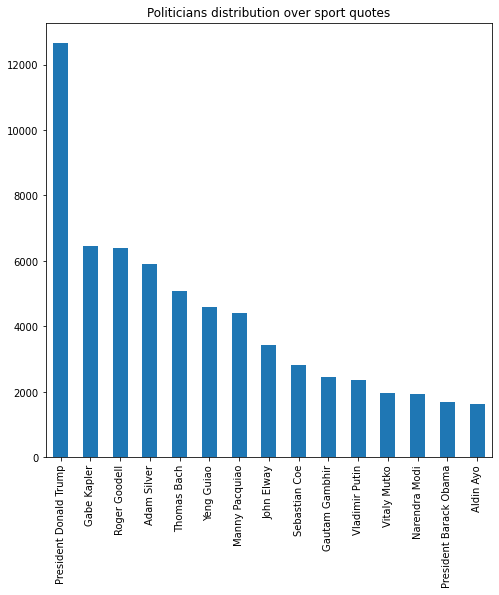

In [ ]:
fig = politician_counts_label_1_qid[0:15].sort_values(by='count', ascending=False).plot(kind='bar',legend=False, figsize=(8, 8), log=False, title='Politicians distribution over sport quotes')
fig.get_figure().savefig('most_present_politicians.png')

In [ ]:
print("Percentage of President Donald Trump presence in politician sport quotes :")
politician_counts_label_1_qid.loc['President Donald Trump', 'count']/sum(politician_counts_label_1_qid['count'])*100

Percentage of President Donald Trump presence in politician sport quotes :


3.4450920579583837

In [ ]:
print("Times President Donald Trump is more cited than the second politician (Gabe Kapler) in politician sport quotes :")
politician_counts_label_1_qid.loc['Gabe Kapler', 'count']/politician_counts_label_1_qid.loc['President Donald Trump', 'count']

Times President Donald Trump is more cited than the second politician (Gabe Kapler) in politician sport quotes :


0.511502885603605

# What is the distribution of the political tendency of the political parties present in the sports quotes (going from far right to far left)?

# + What is the distribution of the political parties present for a specific country?

In [100]:
# Load the dataset with parties

df_sep = map(
    lambda y: pd.read_csv(f'quotes_by_politician_with_party/{str(y)}.csv'), 
    range(2015, 2021)
)
df = pd.concat(df_sep)
df.reset_index(inplace=True, drop=True)
df.head()

,Unnamed: 0,index_q,quoteID,quotation,speaker,qids,date,current_party
0,0,0,2015-08-03-026031,I am not a poster child for the Christie admin...,Bill Pascrell,Q529090,2015-08-03 17:44:16,Q29552
1,1,1,2015-08-03-002773,Accidents occur where the street meets the rai...,Bill Pascrell,Q529090,2015-08-03 17:44:16,Q29552
2,2,2,2015-02-26-089365,These federal investments will go a long way t...,Bill Pascrell,Q529090,2015-02-26 07:55:10,Q29552
3,3,3,2015-02-14-027291,"Looking back, it seems that every several mont...",Bill Pascrell,Q529090,2015-02-14 00:12:20,Q29552
4,4,4,2015-08-03-088419,This is just one of many crossings that need i...,Bill Pascrell,Q529090,2015-08-03 17:44:16,Q29552


We create a map of all party information and parties in the USA to answer two of our research questions

In [101]:
all_parties = df['current_party'].unique()

def extract_party_info(party_qid):
    country, tendency = None, None
    
    if str(party_qid) == 'nan':
        return (country, tendency)
    
    try:
        info = manager.search_party_information(party_qid, is_qid=True)
        
        if info != None:
            country = info['P17'][0] if len(info['P17']) > 0 else None
            tendency = info['P1387'][0] if len(info['P1387']) > 0 else None
        
        if country == 'United States of America':
            parties_usa[party_qid] = country
        
    except:
        return (country, tendency)
    
    return (country, tendency)


# Creating a list of pary infos from each unique party qid
parties_usa = dict()
parties_info = list(map(extract_party_info, all_parties))

print(parties_info[:5])
print(parties_usa['Q29552'])

[('United States of America', None), (None, None), ('Australia', None), ('South Africa', 'centre-left'), ('United Kingdom', 'centre-right')]
United States of America


We fetched data (when possible) to place each party we found in the "left-right political scale"

In [ ]:
res = list(zip(*parties_info))

parties_info_tendency = pd.DataFrame([t for t in res[1] if t != None])

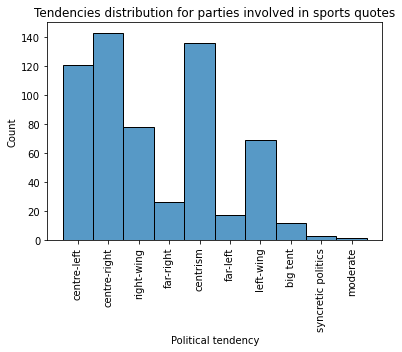

In [103]:
ax = sns.histplot(data=parties_info_tendency, x=0)
ax.set_title('Tendencies distribution for parties involved in sports quotes')
ax.set(xlabel='Political tendency')
ax.tick_params(axis='x', rotation=90)

Let's now look at the distribution of political parties for quotes coming from a politician in an american party

In [128]:
def party_qid_to_name(qid):
    try:
        return manager.search_party_name(qid)['claims']['P1705'][0]['mainsnak']['datavalue']['value']['text']
    except:
        return None

parties_usa_names = { k: party_qid_to_name(k) for k, v in parties_usa.items() if party_qid_to_name(k) is not None }

print(len(parties_usa_names))

18


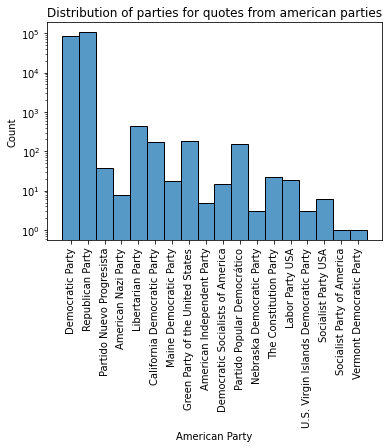

In [149]:
parties_usa_dist = pd.DataFrame(df['current_party'].apply(lambda qid: parties_usa_names.get(qid)).dropna())

ax = sns.histplot(data=parties_usa_dist, x='current_party', log_scale=[False, True])
ax.set_title('Distribution of parties for quotes from american parties')
ax.set(xlabel='American Party')
ax.tick_params(axis='x', rotation=90)

# Extracting sport media information

Let's process the data we already have (i.e. all the sport quotes) to extract the media. To do so, we iterate through every year by chunk to avoid overflowding the memory. Then for each quote, we only keep the quoteID, the speaker ID and the urls. We explode the url and retrieve the domain name to obtain the media and save the file. Therefore we end up with a csv for each year with one line for each combination of quote and media.

This files will be the basis of the rest of the analysis.

In [ ]:
#Creating new files with one line per combination quote/media who quoted it
year = '2020'
incre = 0     # Number of iterations 
nlines = 0    # Number of lines

for chunk in pd.read_csv('/content/drive/MyDrive/ada-sports-quotes/sport-quotes-' + year + '.csv.bz2', compression='bz2', usecols=['quoteID','qids','urls'], converters={'urls': literal_eval, 'qids': literal_eval}, chunksize=100000):
  incre += 1
  sources = [] # Temporary vector to store the medias
  print(incre) # Just to check that everything works as the loop is quite long
  temp = chunk.explode('urls')
  temp = temp.explode('qids').drop_duplicates(['quoteID','urls']) # if a quote ID is twice cited in the same article, drop it
  for url in temp.urls:
    nlines += 1
    res = get_tld(url, as_object=True)
    sources.append(res.domain) # Recover all the medias in the chunk
  temp['media'] = sources
  temp.drop(columns='urls',inplace=True)
  if incre == 1:
    quote_per_media = temp
  else:
    quote_per_media = quote_per_media.append(temp)
print(nlines)
quote_per_media.to_csv('/content/drive/MyDrive/ADA/Speaker_and_media_' + year + '.csv.bz2', compression='bz2')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
14958282


# Studying the medias

Now that we have preprocessed the files to suit our need, we can use them to find out which medias are publishing most of the sport quotes. Then we will keep the 30 biggest to study their tendancy to publish quotes from political speakers. Finally, we will have a look at how the media's tendancy evolves through time.

## Ranking them

First, let's rank them in terms of number of quotes. To do so we will go through each year file generated, extract the number of quotes for each media and sum the results over the years to obtain the score from 2015 to 2020.

In [ ]:
# Obtaining the ranking of the biggest medias
ranking = pd.DataFrame()
years = ['2015','2016','2017','2018','2019','2020']

for year in years:
  quote_per_media = pd.read_csv('/content/drive/MyDrive/ADA/Speaker_and_media_' + year + '.csv.bz2', compression='bz2') # Loading a year
  rank = quote_per_media.media.value_counts() 

  ranking = ranking.add(pd.DataFrame(rank), fill_value=0) # Adding the results year after year

ranking.sort_values('media',ascending=False, inplace=True)
ranking.head(5)

,media
msn,2489333.0
yahoo,2113850.0
eurosport,1068290.0
nbcsports,888715.0
nydailynews,680161.0


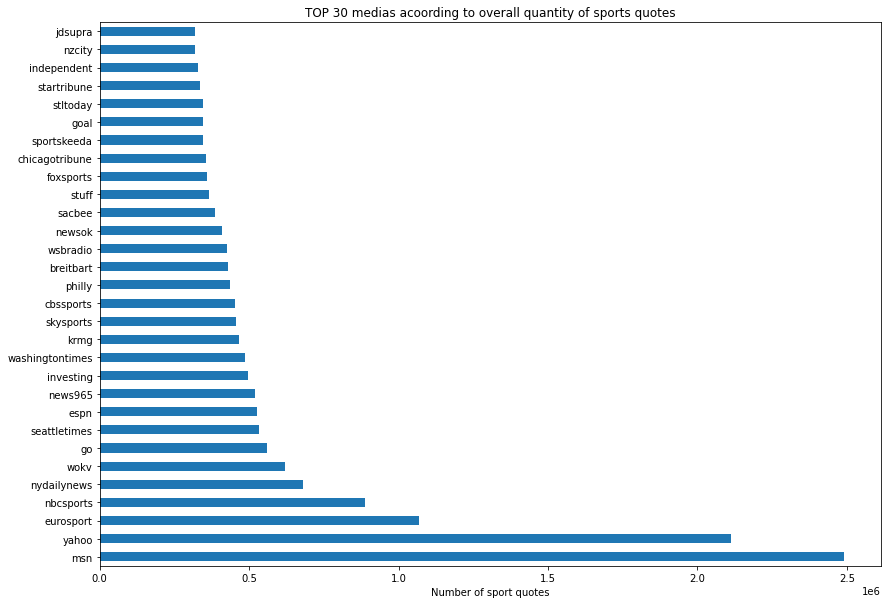

In [ ]:
# Plot
ranking[0:30].media.plot.barh(figsize=(14,10))
plt.xlabel('Number of sport quotes')
plt.title('TOP 30 medias acoording to overall quantity of sports quotes');
plt.savefig('/content/drive/MyDrive/ADA/ranking.png')

## Looking at the proportion of political speakers

Now that we have this ranking, we can have a look at the proportion of political speakers in each of the TOP 30 medias. This is done by checking if the speaker, identified by his wikidata ID, is affiliated to a political party or not.

In [ ]:
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

In [ ]:
vgrouped = pd.DataFrame() # DataFrame with the sum of the count of each type of speaker over the years
vgrouped_percent = pd.DataFrame() # DataFrame with the percentage of each type of speaker for each year the years

for year in years:
  quote_per_media = pd.read_csv('/content/drive/MyDrive/ADA/Speaker_and_media_' + year + '.csv.bz2', compression='bz2')

  # match the speaker_attributes dataset
  speakers = speaker_attributes[speaker_attributes['id'].isin(quote_per_media.qids)]

  # Removing speakers without any known party (i.e. with 'party' == None)
  politicians = speakers[~(speakers['party'].isna())]

  # Attribution of a speaker type
  quote_per_media['Speaker type'] = quote_per_media.qids
  quote_per_media['Speaker type'].loc[quote_per_media.qids.isin(speakers.id)] = 'others'
  quote_per_media['Speaker type'].loc[quote_per_media.qids.isin(politicians.id)] = 'politics'
  quote_per_media = quote_per_media[quote_per_media['Speaker type'].isin(['others','politics'])]

  # Only keeping the quotes from the TOP 30
  quotes_in_main_media = quote_per_media[quote_per_media.media.isin(ranking[0:30].index)] 

  # Grouping by media and speaker type to obtain a df with media as item and count of each speaker type in columns
  grouped = quotes_in_main_media.groupby(['media','Speaker type']).count().quoteID
  grouped = grouped.unstack()
  grouped_percent = grouped.divide(grouped.sum(axis=1),axis=0)*100
  vgrouped_percent = vgrouped_percent.join(grouped_percent.politics,rsuffix=year, how='outer')
  vgrouped = vgrouped.add(grouped,fill_value=0)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
vgrouped.head(5)

Speaker type,others,politics
media,,
breitbart,251974.0,60207.0
cbssports,361441.0,14231.0
chicagotribune,243036.0,21593.0
espn,404510.0,15566.0
eurosport,771500.0,30729.0


In [ ]:
vgrouped_percent.head(5)

,politics,politics2016,politics2017,politics2018,politics2019,politics2020
media,,,,,,
breitbart,33.396716,20.841378,28.309508,17.161791,9.976587,13.277035
cbssports,4.009512,4.649620,5.292903,3.596777,2.466675,3.996541
chicagotribune,6.957664,8.657533,9.135541,7.177795,5.000000,11.764706
espn,5.172775,3.397820,3.879700,3.058334,4.159221,6.608358
eurosport,3.469435,4.618510,5.678588,3.067205,2.167498,6.084856


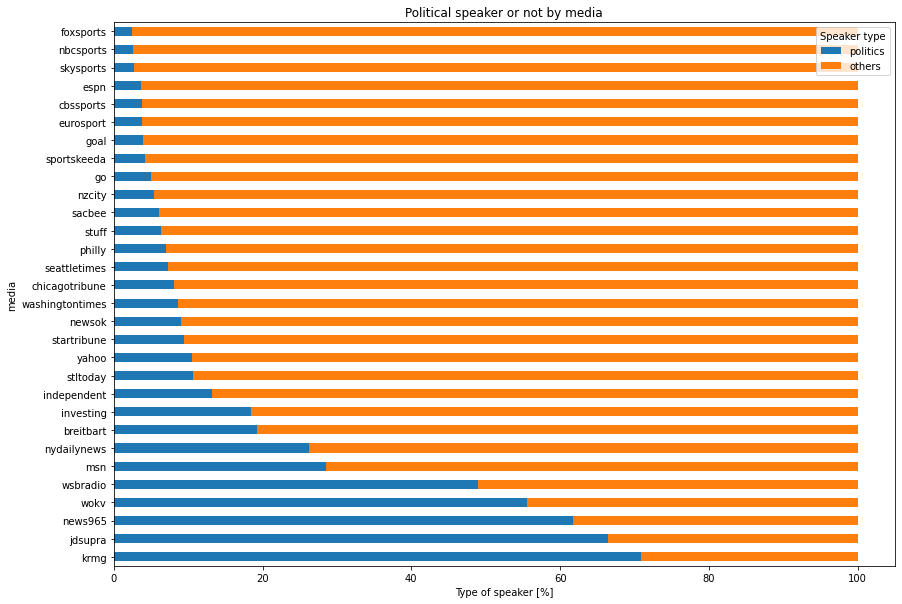

In [ ]:
overall_percent = vgrouped.divide(vgrouped.sum(axis=1),axis=0)*100
overall_percent.sort_values('politics', ascending=False, inplace=True)

# Plot
overall_percent[['politics','others']].plot.barh(sort_columns=True, stacked=True, figsize=(14,10))
plt.xlabel('Type of speaker [%]')
plt.title('Political speaker or not by media');
plt.savefig('/content/drive/MyDrive/ADA/Political_speakers_by_media.png')

## Studying this proportion through time

Now that we have clearly identified important differences between the different medias in terms of speaker proportions, let's have a look at the stability of these values through time. To do so, we first have a look at the standard deviation of the percentage for each media over the years. 

Afterwards, we have a closer look at was is going on through the years for the most unstable medias.

In [ ]:
temp = pd.DataFrame()
temp[years] = vgrouped_percent[vgrouped_percent.columns] # Renaming columns
standard_dev = temp.std(axis=1)
selection = temp[temp.std(axis=1) > 10] # Selecting only the medias with more than 10 STD

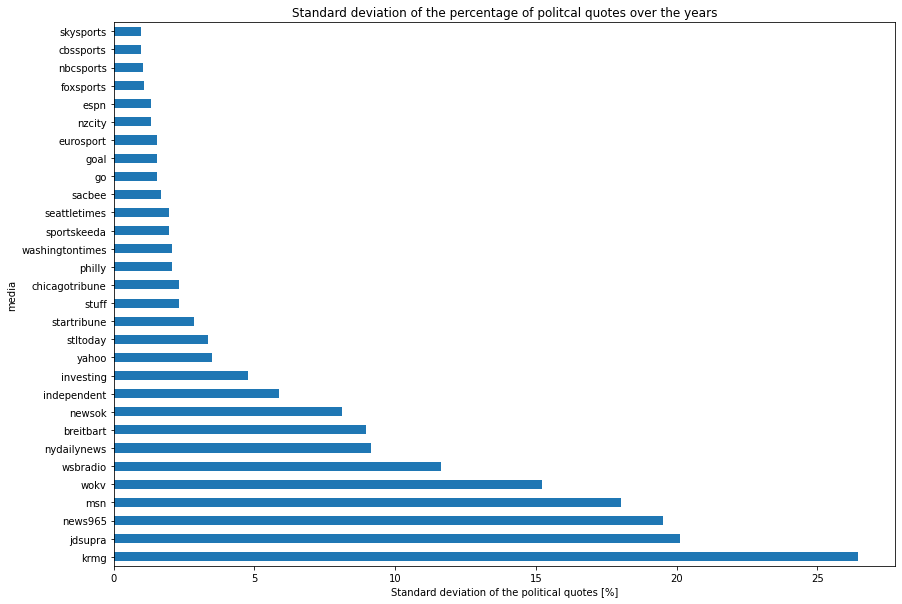

In [ ]:
standard_dev.sort_values(ascending=False, inplace=True)

# Plot
standard_dev.plot.barh(sort_columns=True, stacked=True, figsize=(14,10))
plt.xlabel('Standard deviation of the political quotes [%]')
plt.title('Standard deviation of the percentage of politcal quotes over the years');
plt.savefig('/content/drive/MyDrive/ADA/STD.png')

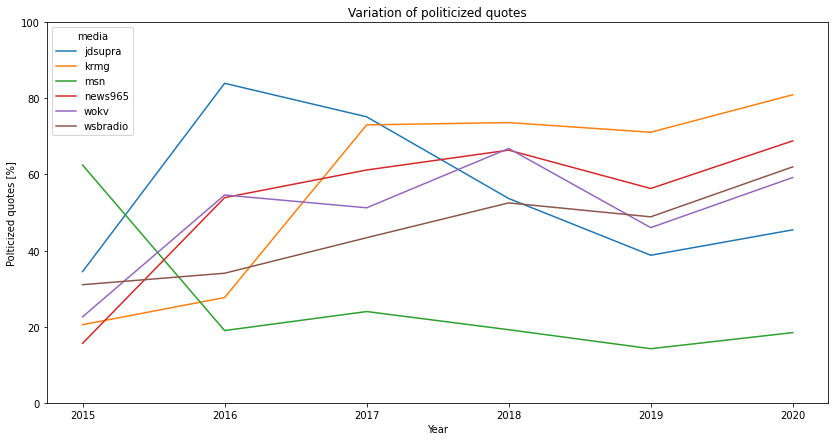

In [ ]:
selection.transpose().plot.line(sort_columns=True,figsize=[14,7],ylim=(0,100))
plt.xlabel('Year')
plt.ylabel('Polticized quotes [%]')
plt.title('Variation of politicized quotes')
plt.savefig('/content/drive/MyDrive/ADA/variation.png')

# All the quotes through time

In this section, we simply want to have a look at the date of publication of each sport quotes pronounced by political speaker. The idea behind it is to have a look at the evolution of this number through time and see if patterns appear such as during the US presidential campaigns.

2020  :  16470
2019  :  52910
2018  :  84907
2017  :  99647
2016  :  48014
2015  :  65212


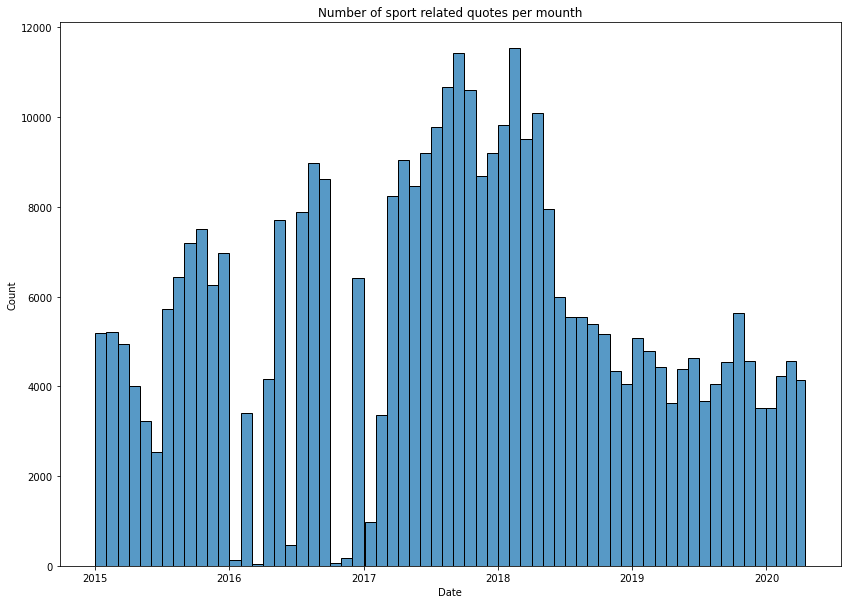

In [ ]:
plt.figure(figsize=[14,10])
years = ['2020','2019','2018','2017','2016','2015']
for year in years:
  test = pd.read_csv('/content/drive/MyDrive/quotes_by_politicians/quotes_by_politicians_' + year + '.csv')
  test['date'] = pd.to_datetime(test.quoteID.str[0:10])
  #plt.figure()
  if test.date[0].year == 2020:
    sns.histplot(test.date, bins = 4);
  else:
    sns.histplot(test.date, bins = 12);
  print(test.date[0].year, ' : ', test.shape[0])
plt.xlabel('Date')
plt.title('Number of sport related quotes per mounth')
plt.savefig('/content/drive/MyDrive/ADA/mounth frequency.png')

# Topic analysis

### Import libraries

In [ ]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
import pandas as pd
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
random.seed(seed)
np.random.seed(seed)

# NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
from gensim.models import LdaMulticore


## Loading politicians sport quotes datasets for all years and concatenate into a single dataframe

Politicians sport quotes refers at quotations said by speakers having a political party. Theses datasets from year 2015 to 2020 have been obtained during Milestone 2.

In [ ]:
quotes_politicians_2015 = pd.read_csv('quotes_by_politicians_2015.csv', index_col='index_q')
quotes_politicians_2016 = pd.read_csv('quotes_by_politicians_2016.csv', index_col='index_q')
quotes_politicians_2017 = pd.read_csv('quotes_by_politicians_2017.csv', index_col='index_q')
quotes_politicians_2018 = pd.read_csv('quotes_by_politicians_2018.csv', index_col='index_q')
quotes_politicians_2019 = pd.read_csv('quotes_by_politicians_2019.csv', index_col='index_q')
quotes_politicians_2020 = pd.read_csv('quotes_by_politicians_2020.csv', index_col='index_q')

frames = [quotes_politicians_2015, quotes_politicians_2016, quotes_politicians_2017, quotes_politicians_2018, quotes_politicians_2019, quotes_politicians_2020]
quotes_politicians = pd.concat(frames, ignore_index=True)

# Check the number of lines of the new dataframe is good
print('Sum of quotes for years :', quotes_politicians_2015.shape[0] + quotes_politicians_2016.shape[0] + quotes_politicians_2017.shape[0] + quotes_politicians_2018.shape[0] + quotes_politicians_2019.shape[0] + quotes_politicians_2020.shape[0])
print('New dataframe length :', quotes_politicians.shape[0])

Sum of quotes for years : 367160
New dataframe length : 367160


## Tokenization and LDA analysis for topic detection

In [ ]:
# The following code is inspired from ADA Tutorial 10/11 on text analysis and topic detection using LDA

# Use spacy library for natural language processing, using the sm (small) package of en_core_web
nlp = spacy.load('en_core_web_sm')

# Defing stopwords from spacy
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

# Apply nlp() to whole dataset
quotations_nlp = quotes_politicians['quotation'].apply(lambda x: nlp(x.lower()))

# Split string into tokens
docs = list()
for doc in quotations_nlp:
    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
    docs.append(doc)

# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 2 times or more).
bigram = Phrases(docs, min_count=2)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
            
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]


# LDA
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6, passes=params['passes'], random_state=params['random_state'])

# Topic assignment for every quotation in the dataframe
sent_to_cluster = list()
for n, doc in enumerate(corpus):
    if doc:
      cluster = max(model[doc], key=lambda x:x[1])
      sent_to_cluster.append(cluster[0])
    else:
      sent_to_cluster.append(np.nan)

# Add a column of the topic for each quotation
quotes_politicians['topic'] = sent_to_cluster


# Plot topics
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

## Rename the topics by their actual subject
For this task, we just use some test strings (words of each topic) which only fall into one of the 4 topics (first is politics, second id daily life, third and fourth are sports).

Using the model we just computed, we can print the probability for each string to be in a certain topic.

In [ ]:
test = pd.DataFrame({'text':['politics government law economy politician', 'think good play like people', 'sport country athlete', 'world team will win']})['text'].apply(lambda x: nlp(x.lower()))

# Using the same pipeline as before
# Keep only words (no numbers, no punctuation).
# Lemmatize tokens, remove punctuation and remove stopwords.
docs_test = list()
for doc_test in test:
    doc_test = [token.lemma_ for token in doc_test if token.is_alpha and not token.is_stop]
    docs_test.append(doc_test)
    
corpus_test = [dictionary.doc2bow(doc_test) for doc_test in docs_test]
for doc_test in corpus_test:
    # Apply model and print topic assignement probability
    print(model[doc_test])

[(0, 0.0417511), (1, 0.042151444), (2, 0.04556301), (3, 0.8705345)]
[(0, 0.04193054), (1, 0.8734921), (2, 0.04215153), (3, 0.042425863)]
[(0, 0.063471034), (1, 0.06250212), (2, 0.8112054), (3, 0.062821455)]
[(0, 0.80908656), (1, 0.065360256), (2, 0.06305251), (3, 0.06250065)]


As we know the real topic of each test string, we can assign the topic name to the topic number. 
* 0 is sports 1
* 1 is daily life
* 2 is sports 2
* 3 is politics

In [ ]:
quotes_politicians['topic'] = quotes_politicians['topic'].replace(2,'sports 2').replace(3, 'politics').replace(1,'daily_life').replace(0,'sports 1')

# Using the date column to extract the year of each quote
quotes_politicians['year'] = pd.to_datetime(quotes_politicians['date']).dt.year
quotes_politicians

,quoteID,quotation,speaker,qids,date,topic,year
0,2015-08-03-026031,I am not a poster child for the Christie admin...,Bill Pascrell,Q529090,2015-08-03 17:44:16,politics,2015
1,2015-08-03-002773,Accidents occur where the street meets the rai...,Bill Pascrell,Q529090,2015-08-03 17:44:16,politics,2015
2,2015-02-26-089365,These federal investments will go a long way t...,Bill Pascrell,Q529090,2015-02-26 07:55:10,politics,2015
3,2015-02-14-027291,"Looking back, it seems that every several mont...",Bill Pascrell,Q529090,2015-02-14 00:12:20,politics,2015
4,2015-08-03-088419,This is just one of many crossings that need i...,Bill Pascrell,Q529090,2015-08-03 17:44:16,politics,2015
...,...,...,...,...,...,...,...
367155,2020-03-31-073879,"Whatever we do, our ultimate goal is really to...",Harry LaRosiliere,Q16186333,2020-03-31 17:45:31,daily_life,2020
367156,2020-02-26-025030,"I guess Monmouth, Rutgers, Seton Hall could [ ...",John McCain,Q10390,2020-02-26 14:21:57,sports 2,2020
367157,2020-03-20-029492,if only we had responsibly managed our budgets...,Chip Roy,Q58333615,2020-03-20 10:00:00,sports 2,2020
367158,2020-02-26-071313,There is no sports facility for children in th...,Vijay Girkar,Q28113042,2020-02-26 01:47:50,sports 2,2020


## Plot the results : percentage of each quotes by topic and by year

<AxesSubplot:xlabel='year', ylabel='Pourcentage [%]'>

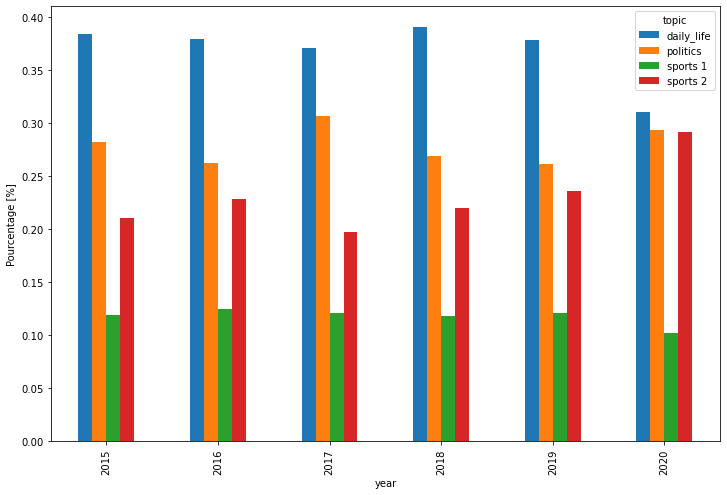

In [ ]:
quotes_politicians.groupby('year')['topic'].value_counts().div(quotes_politicians.groupby('year').size()).unstack().plot.bar(figsize=[12,8], ylabel='Pourcentage [%]')

In [ ]:
quotes_politicians.to_csv('quotes_politicians_topic.csv')